In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# 用SAM自动生成物体遮罩
# *Automatically generating object masks with SAM*

由于SAM可以有效地处理提示信息，因此可以通过在一幅图像上对大量的提示信息进行采样来生成整个图像的遮罩。这个方法被用来生成数据集SA-1B。

`SamAutomaticMaskGenerator`类实现了这种能力。它的工作方式是在图像上的网格中对单点输入提示（单点标记）进行采样，SAM可以从每个提示中预测多个遮罩。然后，遮罩被过滤以保证质量，并使用非最大限度的压制进行重复计算。额外的选项允许进一步提高遮罩的质量和数量，如在图像的多个剪切框（标记框）上运行预测，或对遮罩进行后处理以去除小的不连接区域和洞。  

原文：  
*Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.*

*The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.*

## 环境设置
## *Environment Set-up*

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

## 示例图片
## *Example image*

In [8]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

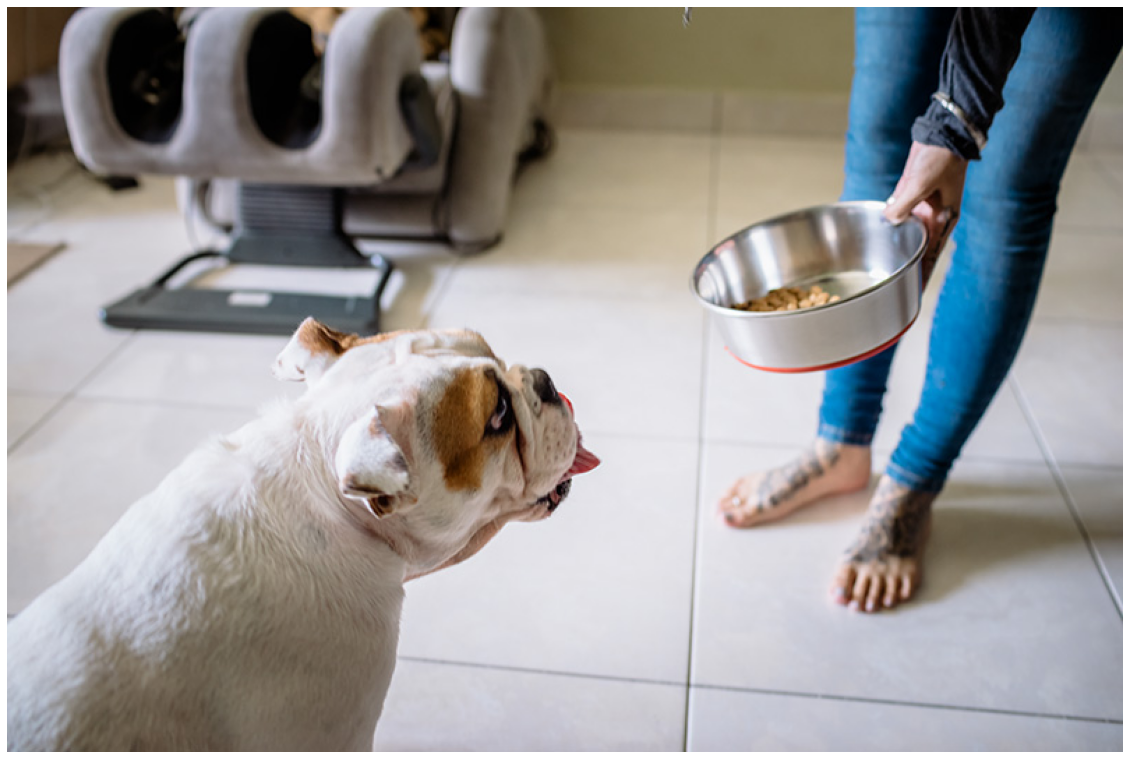

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## 自动生成遮罩
## *Automatic mask generation*

要运行自动遮罩生成，需要提供一个SAM模型给`SamAutomaticMaskGenerator`类。将sam_checkpoint的路径设置为SAM模型文件路径。建议在CUDA上运行并使用默认模型。  
原文：  
*To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.*

In [10]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = r"D:\download\sam\sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

要生成掩码的话，只需对图像对象运行`generate`即可。  
原文：  
*To generate masks, just run `generate` on an image.*

In [11]:
masks = mask_generator.generate(image)

遮罩生成后将返回一个包含多个遮罩的列表，其中每个遮罩是一个包含掩码及各种数据的字典。字典中的key分别是：  
* `segmentation` : 遮罩
* `area`：遮罩的面积，单位是像素
* `bbox`：以XYWH格式表示的遮罩的边界盒
* `predicted_iou`：模型自己对遮罩质量的预测
* `point_coords`：产生此遮罩的采样输入点
* `stability_score` : 遮罩质量的额外衡量标准
* `crop_box`：用于生成此遮罩的XYWH格式图像的裁剪  
  
原文：  
*Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:*
* *`segmentation` : the mask*
* *`area` : the area of the mask in pixels*
* *`bbox` : the boundary box of the mask in XYWH format*
* *`predicted_iou` : the model's own prediction for the quality of the mask*
* *`point_coords` : the sampled input point that generated this mask*
* *`stability_score` : an additional measure of mask quality*
* *`crop_box` : the crop of the image used to generate this mask in XYWH format*

In [31]:
print(len(masks))
print(masks[0].keys())

44
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


显示叠加在图像上的所有遮罩。  
原文：  
*Show all the masks overlayed on the image.*

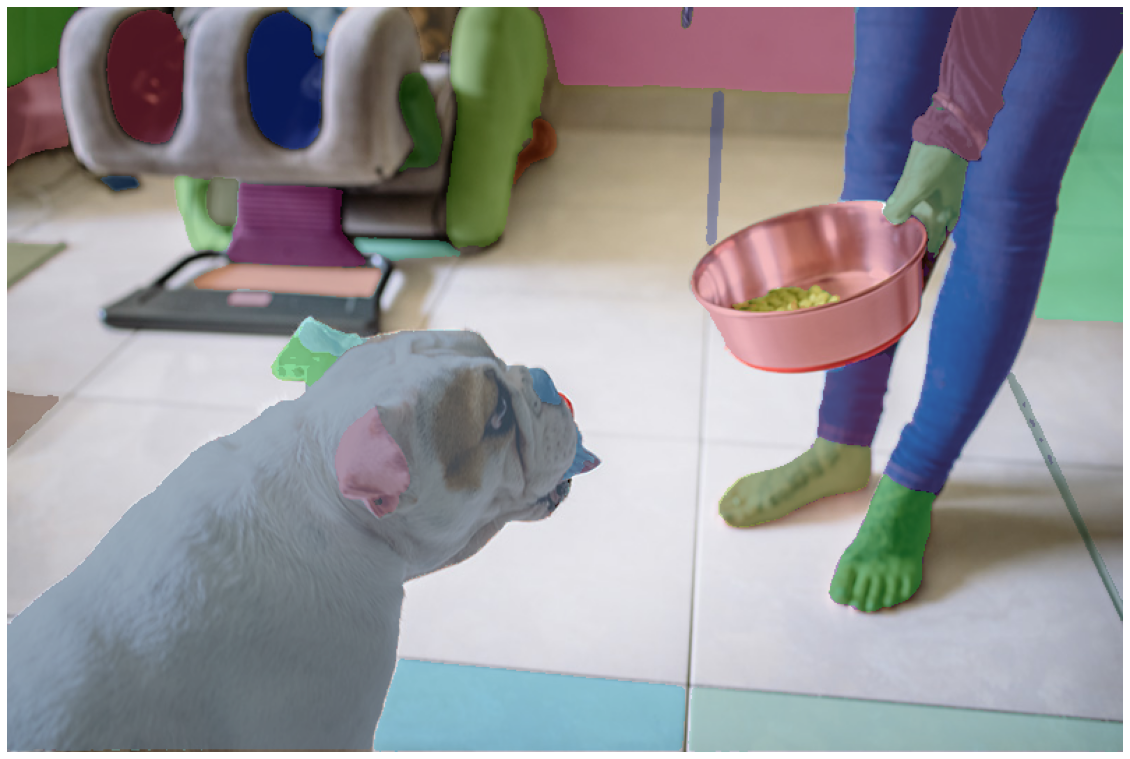

In [32]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## 自动掩码生成的选项
## *Automatic mask generation options*

在自动遮罩生成功能中，有几个可以调整的参数，用于控制点的采样密度和去除低质量或重复遮罩的阈值。此外，自动生成功能可以在标记目标框框后再执行预测，以便在较小的物体上获得更好的性能，并且后处理功能可以去除杂散像素和孔洞。下面是对一个多遮罩进行采样的配置示例：  
原文：  
*There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:*

In [33]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [34]:
masks2 = mask_generator_2.generate(image)

In [35]:
len(masks2)

63

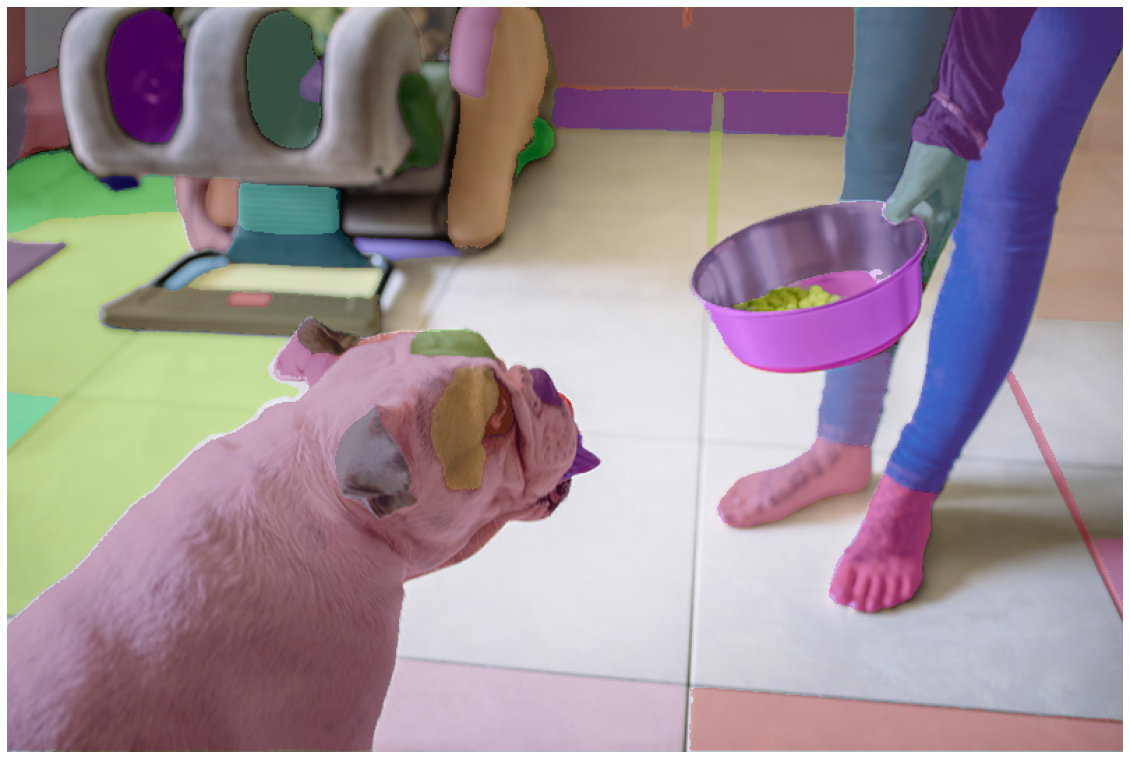

In [36]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 